In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

<!--<h4><b>1. 데이터 로딩 및 초기 처리</b></h3>-->

In [2]:
DATA = "./raw data/D배수지.csv"
DF = pd.read_csv(DATA, encoding='euc-kr', dtype={'시각': str})

# 1. 시각 문자열 → datetime 변환
DF['시각'] = pd.to_datetime(DF['시각'], errors='coerce')

# 2. 시각 정렬 및 중복 시각 보정 (30초 간격 추가)
DF = DF.sort_values('시각')
DF['_idx'] = DF.groupby('시각').cumcount()
DF['시각_복원'] = DF['시각'] + pd.to_timedelta(DF['_idx'] * 30, unit='s')

# 3. 시계열 인덱스 지정
DF = DF.drop(columns=['_idx', '시각'])  # '시각' 컬럼 제거
DF = DF.set_index('시각_복원')
DF.index.name = '시각'

In [3]:
print("✅ 시간 간격 분포:\n", DF.index.to_series().diff().value_counts().sort_index(), "\n")
print("✅ 초 단위 분포:\n", DF.index.to_series().dt.second.value_counts().sort_index(), "\n")
print("✅ 중복 시각 개수:", DF.index.duplicated().sum(), "\n")
print("✅ 앞부분 시각 확인:\n", DF.index[:10])

✅ 시간 간격 분포:
 시각
0 days 00:00:30    325440
Name: count, dtype: int64 

✅ 초 단위 분포:
 시각
0     162721
30    162720
Name: count, dtype: int64 

✅ 중복 시각 개수: 0 

✅ 앞부분 시각 확인:
 DatetimeIndex(['2024-09-25 00:00:00', '2024-09-25 00:00:30',
               '2024-09-25 00:01:00', '2024-09-25 00:01:30',
               '2024-09-25 00:02:00', '2024-09-25 00:02:30',
               '2024-09-25 00:03:00', '2024-09-25 00:03:30',
               '2024-09-25 00:04:00', '2024-09-25 00:04:30'],
              dtype='datetime64[ns]', name='시각', freq=None)


In [4]:
# 필요 없는 컬럼 제거
DF = DF[[col for col in DF.columns if '방향' not in col and '압력' not in col]]

In [5]:
def preprocess_DF(DF, threshold=0.98):
    # 원래 컬럼 집합 저장
    original_cols = set(DF.columns)

    # 삭제 기준 계산
    null_ratio = DF.isnull().mean()
    zero_ratio = (DF == 0).mean(numeric_only=True)  # ← 중요: 숫자형만 포함

    null_cols = null_ratio[null_ratio >= threshold].index.tolist()
    zero_cols = zero_ratio[zero_ratio >= threshold].index.tolist()

    # 삭제 대상 컬럼 목록
    cols_to_drop = list(set(null_cols + zero_cols))

    # 전처리 전 컬럼 수
    before_cols = DF.shape[1]

    # 컬럼 삭제
    DF = DF.drop(columns=cols_to_drop, errors='ignore')

    # 전처리 후 컬럼 수
    after_cols = DF.shape[1]

    # 삭제 컬럼 목록
    deleted_cols = list(original_cols - set(DF.columns))

    # 로그 출력
    print(f"총 컬럼 수: {before_cols} → {after_cols} (삭제: {before_cols - after_cols})")
    if deleted_cols:
        print(f"삭제된 컬럼: {sorted(deleted_cols)}")
    else:
        print("삭제 없음")

    # ✅ 수치형 컬럼만 선택해서 음수 → NaN → 보간
    numeric_cols = DF.select_dtypes(include='number').columns
    DF[numeric_cols] = DF[numeric_cols].mask(DF[numeric_cols] < 0, np.nan)
    DF[numeric_cols] = DF[numeric_cols].bfill().ffill()

    return DF

In [6]:
DF = preprocess_DF(DF)

총 컬럼 수: 24 → 17 (삭제: 7)
삭제된 컬럼: ['D_배수지_수위3', 'D_배수지_수위4', 'D_배수지_수위5', 'D_배수지_수위6', 'D_배수지_유입개도4', 'D_배수지_유입개도5', 'D_배수지_유입개도6']


In [7]:
def check_remaining_inactive_columns(df, threshold=0.98, std_threshold=1e-4, verbose=True):
    """
    결측치, 0값 컬럼을 점검 (압력/방향/개도 조건 제외)
    """
    null_ratio = df.isnull().mean()
    zero_ratio = df.select_dtypes(include='number').eq(0).mean()
    std_is_low = df.select_dtypes(include='number').std() < std_threshold

    # 삭제 대상 컬럼 (아무런 제외 조건 없음)
    null_cols = null_ratio[null_ratio >= threshold].index.tolist()
    zero_cols = zero_ratio[zero_ratio >= threshold].index.tolist()

    if verbose:
        print("\n🧹 남아있는 비활성(결측/0) 컬럼 점검")
        if null_cols:
            print(f"  ⚠️ 결측치 ≥ {threshold*100:.0f}% 컬럼:", null_cols)
        if zero_cols:
            print(f"  ⚠️ 0값 ≥ {threshold*100:.0f}% 컬럼:", zero_cols)

        if not (null_cols or zero_cols):
            print("  ✅ 삭제할 컬럼 없음")

    return {"결측": null_cols, "0값": zero_cols}

In [8]:
check_remaining_inactive_columns(DF)


🧹 남아있는 비활성(결측/0) 컬럼 점검
  ⚠️ 0값 ≥ 98% 컬럼: ['가단계_D배수지_유입유량1']


{'결측': [], '0값': ['가단계_D배수지_유입유량1']}

<!--<hr>
<h4><b>2. 데이터 전처리</b></h3>

- 98% 이상 결측 or 0인 컬럼 제거
- 음수값은 NaN으로 처리 후 보간(bfill, ffill)-->

In [9]:
DF = preprocess_DF(DF)

총 컬럼 수: 17 → 16 (삭제: 1)
삭제된 컬럼: ['가단계_D배수지_유입유량1']


In [10]:
check_remaining_inactive_columns(DF)


🧹 남아있는 비활성(결측/0) 컬럼 점검
  ✅ 삭제할 컬럼 없음


{'결측': [], '0값': []}

In [11]:
print(f"\n📌 {len(DF.columns)}개")
print(DF.columns.tolist())


📌 16개
['D_배수지_유출유량2', 'D_배수지_수위2', 'D_배수지_수위1', 'D_배수지_수위8', 'D_배수지_수위7', 'D_배수지_유입유량1', 'D_배수지_유입유량2', 'D_배수지_유출유량1', '나단계_D배수지_유입유량1', 'D_배수지_유출개도2', 'D_배수지_유입개도2', 'D_배수지_유출개도1', 'D_배수지_유입개도1', 'D_배수지_유입개도8', 'D_배수지_유입개도7', 'D_배수지_유입개도3']


<!--<hr>

### ***청소구간 탐지***

<hr>-->

<hr>

### ***유량 단위 보정: ㎥/h → ㎥/30s*** (1/120)

<hr>

In [12]:
# 유량 단위 보정: ㎥/h → ㎥/30s (1/120)
flow_cols = [col for col in DF.columns if '유량' in col]
for col in flow_cols:
    DF[col] = DF[col] / 120  # ㎥/h → ㎥/30초

In [ ]:
# DF[flow_cols]

,D_배수지_유출유량2,D_배수지_유입유량1,D_배수지_유입유량2,D_배수지_유출유량1,나단계_D배수지_유입유량1
시각,,,,,
2024-09-25 00:00:00,2.983333,7.475000,6.841667,5.566667,13.783333
2024-09-25 00:00:30,2.991667,7.458333,6.850000,5.600000,13.750000
2024-09-25 00:01:00,3.100000,7.325000,6.833333,5.708333,13.633333
2024-09-25 00:01:30,3.033333,7.325000,6.800000,5.541667,13.541667
2024-09-25 00:02:00,3.016667,7.200000,6.791667,5.500000,13.591667
...,...,...,...,...,...
2025-01-15 23:58:00,3.458333,7.791667,7.033333,4.825000,14.508333
2025-01-15 23:58:30,3.591667,8.125000,7.025000,4.850000,14.566667
2025-01-15 23:59:00,3.591667,8.125000,7.025000,4.933333,14.433333


### 청소구간 탐지

In [14]:
from typing import List, Tuple

# ✅ 이상치 탐지
def detect_outliers_mad(df: pd.DataFrame, column: str, scale: float = 3.5) -> pd.Series:
    series = df[column].dropna()
    median = series.median()
    mad = np.median(np.abs(series - median))
    mad = mad if mad != 0 else 1e-6
    upper = median + scale * mad
    lower = median - scale * mad
    return (df[column] > upper) | (df[column] < lower)

# ✅ 평탄 구간 탐지
def detect_flat_regions(df: pd.DataFrame, column: str, window: int = 60, std_threshold: float = 0.02) -> pd.Series:
    return df[column].rolling(window=window, min_periods=1).std() < std_threshold

# ✅ 청소 구간 탐지
def find_event_ranges(mask: pd.Series, min_duration='10h', min_count=1200, max_gap='1min') -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    times = mask[mask].index
    if times.empty: return []

    ranges = []
    start = times[0]

    for i in range(1, len(times)):
        if times[i] - times[i-1] > pd.Timedelta(max_gap):
            end = times[i-1]
            if (end - start >= pd.Timedelta(min_duration)) and ((end - start).total_seconds() // 30 >= min_count):
                ranges.append((start, end))
            start = times[i]

    end = times[-1]
    if (end - start >= pd.Timedelta(min_duration)) and ((end - start).total_seconds() // 30 >= min_count):
        ranges.append((start, end))

    return ranges

# ✅ 시각화: 원본 vs 대체 비교
def plot_cleaning_comparison(original_df, replaced_df, column, cleaning_ranges, reservoir_name=None):
    plt.figure(figsize=(15, 5))
    plt.plot(original_df.index, original_df[column], label='원본', color='red', linestyle='--', linewidth=1.2)
    plt.plot(replaced_df.index, replaced_df[column], label='대체 후', color='blue', linestyle='-', linewidth=1.5)
    for start, end in cleaning_ranges:
        plt.axvspan(start, end, color='red', alpha=0.2)
    plt.title(f"{reservoir_name or ''} | {column} 청소 전후 비교", fontsize=14)
    plt.xlabel("시각")
    plt.ylabel("값")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📌 D_배수지_수위2 | 청소 구간 수: 2
   └─ 구간 1: 2024-10-19 01:29 ~ 2024-10-21 17:32
   └─ 구간 2: 2024-12-12 12:03 ~ 2024-12-13 15:55


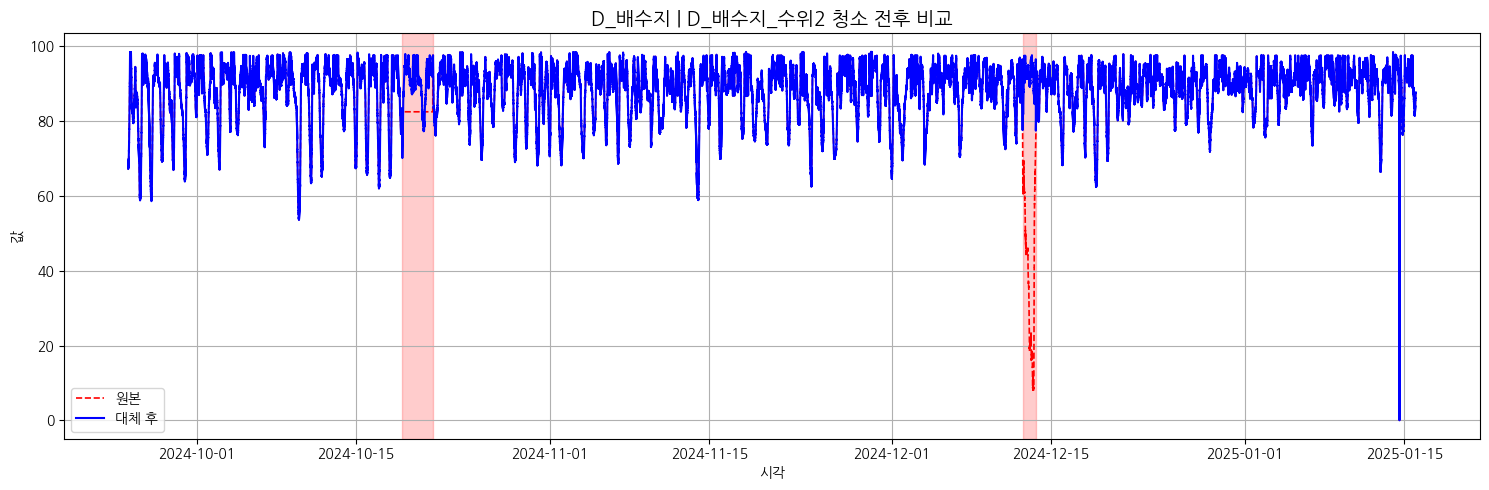


📌 D_배수지_수위1 | 청소 구간 수: 2
   └─ 구간 1: 2024-10-19 01:28 ~ 2024-10-21 17:32
   └─ 구간 2: 2024-12-11 17:38 ~ 2024-12-12 12:57


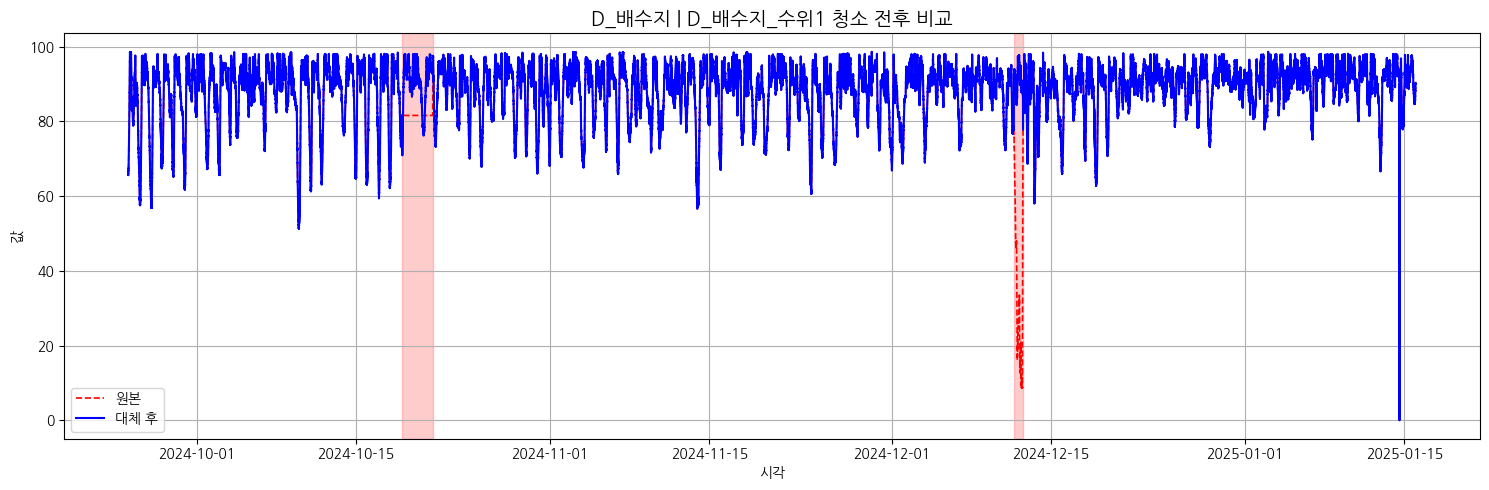


📌 D_배수지_수위8 | 청소 구간 수: 2
   └─ 구간 1: 2024-10-18 20:21 ~ 2024-10-21 17:32
   └─ 구간 2: 2024-12-10 18:24 ~ 2024-12-11 13:43


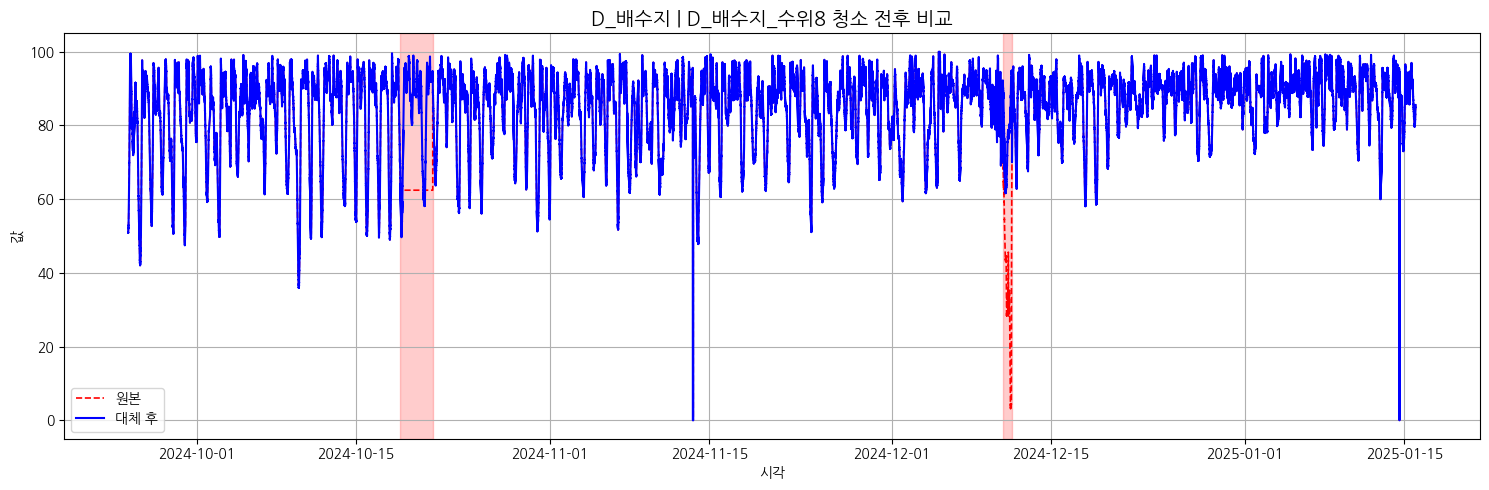


📌 D_배수지_수위7 | 청소 구간 수: 2
   └─ 구간 1: 2024-10-18 20:15 ~ 2024-10-21 17:32
   └─ 구간 2: 2024-12-09 19:30 ~ 2024-12-10 14:16


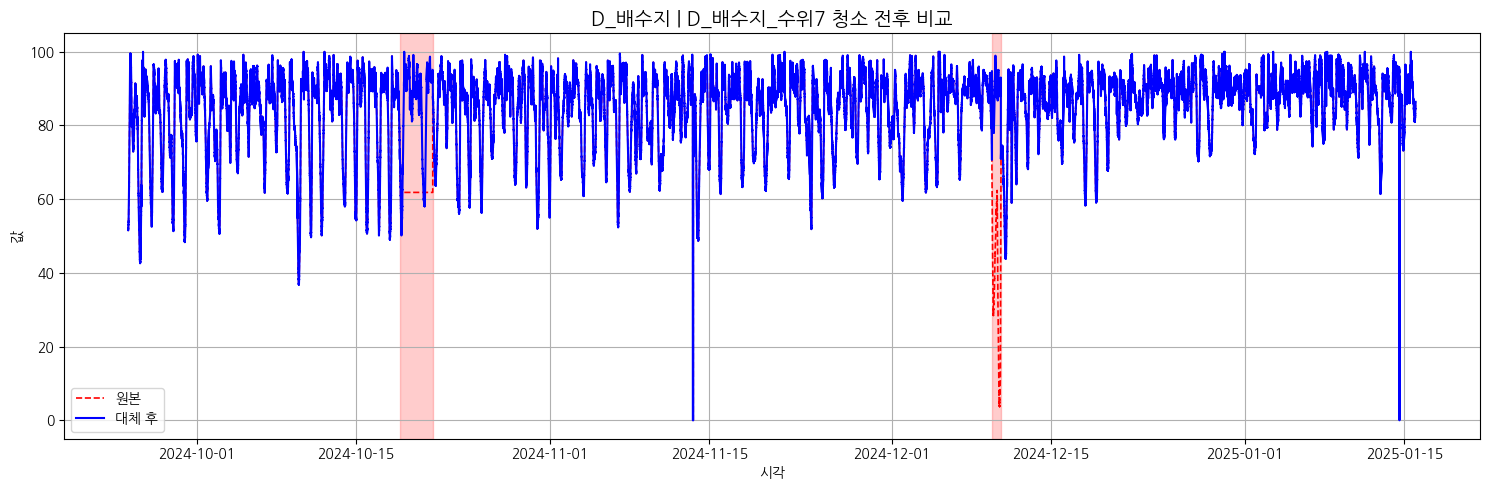

In [15]:
#  수위 컬럼 리스트 추출
level_columns = [col for col in DF.columns if '수위' in col]

# 청소 구간 저장용 딕셔너리
level_cleaning_map = {}

for col in level_columns:
    # 1. 원본 복사
    original_df = DF[[col]].copy()
    # 2. 이상치 + 평탄 마스크
    outlier_mask = detect_outliers_mad(DF, col)
    flat_mask = detect_flat_regions(DF, col)
    combined_mask = outlier_mask | flat_mask
    # 3. 청소 구간 탐지
    cleaning_ranges = find_event_ranges(combined_mask)
    # 4. 청소 구간 기록
    level_cleaning_map[col] = cleaning_ranges

    print(f"\n📌 {col} | 청소 구간 수: {len(cleaning_ranges)}")
    for i, (start, end) in enumerate(cleaning_ranges, 1):
        print(f"   └─ 구간 {i}: {start.strftime('%Y-%m-%d %H:%M')} ~ {end.strftime('%Y-%m-%d %H:%M')}")

    # 5. 대체 (1주 전 데이터로 복원)
    for start, end in cleaning_ranges:
        prev_start = start - pd.Timedelta(weeks=1)
        prev_end = end - pd.Timedelta(weeks=1)
        try:
            cur_range = DF.loc[start:end]
            prev_range = DF.loc[prev_start:prev_end]
            min_len = min(len(cur_range), len(prev_range))
            if min_len > 0:
                idx = cur_range.index[:min_len]
                DF.loc[idx, col] = prev_range[col].values[:min_len]
            else:
                print(f"⚠️ 대체 실패 (길이 불일치): {start} ~ {end}")
        except Exception as e:
            print(f"⚠️ 예외 발생: {start} ~ {end} | {e}")

    # 6. 시각화
    plot_cleaning_comparison(original_df, DF, col, cleaning_ranges, reservoir_name="D_배수지")

In [16]:
level_cleaning_map

{'D_배수지_수위2': [(Timestamp('2024-10-19 01:29:30'),
   Timestamp('2024-10-21 17:32:00')),
  (Timestamp('2024-12-12 12:03:30'), Timestamp('2024-12-13 15:55:00'))],
 'D_배수지_수위1': [(Timestamp('2024-10-19 01:28:30'),
   Timestamp('2024-10-21 17:32:00')),
  (Timestamp('2024-12-11 17:38:00'), Timestamp('2024-12-12 12:57:30'))],
 'D_배수지_수위8': [(Timestamp('2024-10-18 20:21:00'),
   Timestamp('2024-10-21 17:32:00')),
  (Timestamp('2024-12-10 18:24:30'), Timestamp('2024-12-11 13:43:30'))],
 'D_배수지_수위7': [(Timestamp('2024-10-18 20:15:00'),
   Timestamp('2024-10-21 17:32:00')),
  (Timestamp('2024-12-09 19:30:30'), Timestamp('2024-12-10 14:16:00'))]}

<hr>
<hr>

In [17]:
linked_map = {
    ("A_배수지_수위1", "A_배수지_수위2"): ["A_배수지_유입유량1", "A_배수지_유출유량1"],
    ("A_배수지_수위3", "A_배수지_수위4"): ["A_배수지_유입유량1", "A_배수지_유출유량2"],
}

<hr>
<hr>

In [18]:
def merge_ranges_enveloping(ranges: List[Tuple[pd.Timestamp, pd.Timestamp]]) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    if not ranges:
        return []
    sorted_ranges = sorted(ranges, key=lambda x: x[0])
    merged = [sorted_ranges[0]]
    for current_start, current_end in sorted_ranges[1:]:
        last_start, last_end = merged[-1]
        if current_start <= last_end:
            merged[-1] = (min(last_start, current_start), max(last_end, current_end))
        else:
            merged.append((current_start, current_end))
    return merged

In [19]:
def merge_ranges_enveloping(ranges: List[Tuple[pd.Timestamp, pd.Timestamp]]) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    if not ranges:
        return []
    sorted_ranges = sorted(ranges, key=lambda x: x[0])
    merged = [sorted_ranges[0]]
    for current_start, current_end in sorted_ranges[1:]:
        last_start, last_end = merged[-1]
        if current_start <= last_end:
            merged[-1] = (min(last_start, current_start), max(last_end, current_end))
        else:
            merged.append((current_start, current_end))
    return merged

In [ ]:
for level_cols, flow_cols in linked_map.items():
    # 1. 수위별 청소구간 합치기
    combined_ranges = []
    for lv in level_cols:
        combined_ranges.extend(level_cleaning_map.get(lv, []))

    merged_ranges = merge_ranges_enveloping(combined_ranges)

    # 2. 유량 컬럼별로 복원 및 시각화
    for flow_col in flow_cols:
        if flow_col not in DF.columns:
            print(f"❌ 유량 컬럼 없음: {flow_col}")
            continue

        original_df = DF[[flow_col]].copy()
        for start, end in merged_ranges:
            prev_start = start - pd.Timedelta(weeks=1)
            prev_end = end - pd.Timedelta(weeks=1)
            try:
                cur_range = DF.loc[start:end]
                prev_range = DF.loc[prev_start:prev_end]
                min_len = min(len(cur_range), len(prev_range))
                if min_len > 0:
                    idx = cur_range.index[:min_len]
                    DF.loc[idx, flow_col] = prev_range[flow_col].values[:min_len]
                    print(f"✅ 대체 완료: {flow_col} | {start} ~ {end}")
                else:
                    print(f"⚠️ 길이 부족: {flow_col} | {start} ~ {end}")
            except Exception as e:
                print(f"⚠️ 예외 발생: {flow_col} | {start} ~ {end} | {e}")

        # 시각화
        plot_cleaning_comparison(original_df, DF, flow_col, merged_ranges, reservoir_name="D_배수지")

❌ 유량 컬럼 없음: A_배수지_유입유량1
❌ 유량 컬럼 없음: A_배수지_유출유량1
❌ 유량 컬럼 없음: A_배수지_유입유량1
❌ 유량 컬럼 없음: A_배수지_유출유량2


<hr>

#### 시각화

In [21]:
def plot_columns_with_keyword(df, keyword='유출유량', max_cols=12, layout=(4, 3), figsize=(18, 10)):
    """
    특정 키워드를 포함하는 컬럼들에 대해 시계열 그래프를 그리는 함수.
    
    Parameters:
    - df: DataFrame (시계열 인덱스 포함)
    - keyword: 문자열, 포함된 컬럼을 찾을 키워드 (예: '수위', '유출유량')
    - max_cols: 최대 시각화할 컬럼 수
    - layout: (행, 열) 형태로 subplot 배치
    - figsize: 전체 figure 크기
    """

    # 대상 컬럼 필터링
    plot_cols = [col for col in df.columns if keyword in col][:max_cols]
    total = len(plot_cols)

    if total == 0:
        print(f"❌ '{keyword}'를 포함한 컬럼이 없습니다.")
        return

    rows, cols = layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for i, col in enumerate(plot_cols):
        ax = axes[i]
        ax.plot(df.index, df[col], label=col, linewidth=1.5)
        ax.set_title(col)
        ax.grid(True)
        ax.legend(fontsize=9)

    # 빈 subplot 숨기기
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"'{keyword}' 관련 컬럼 시계열 (최대 {max_cols}개)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [22]:
DF.columns

Index(['D_배수지_유출유량2', 'D_배수지_수위2', 'D_배수지_수위1', 'D_배수지_수위8', 'D_배수지_수위7',
       'D_배수지_유입유량1', 'D_배수지_유입유량2', 'D_배수지_유출유량1', '나단계_D배수지_유입유량1',
       'D_배수지_유출개도2', 'D_배수지_유입개도2', 'D_배수지_유출개도1', 'D_배수지_유입개도1',
       'D_배수지_유입개도8', 'D_배수지_유입개도7', 'D_배수지_유입개도3'],
      dtype='object')

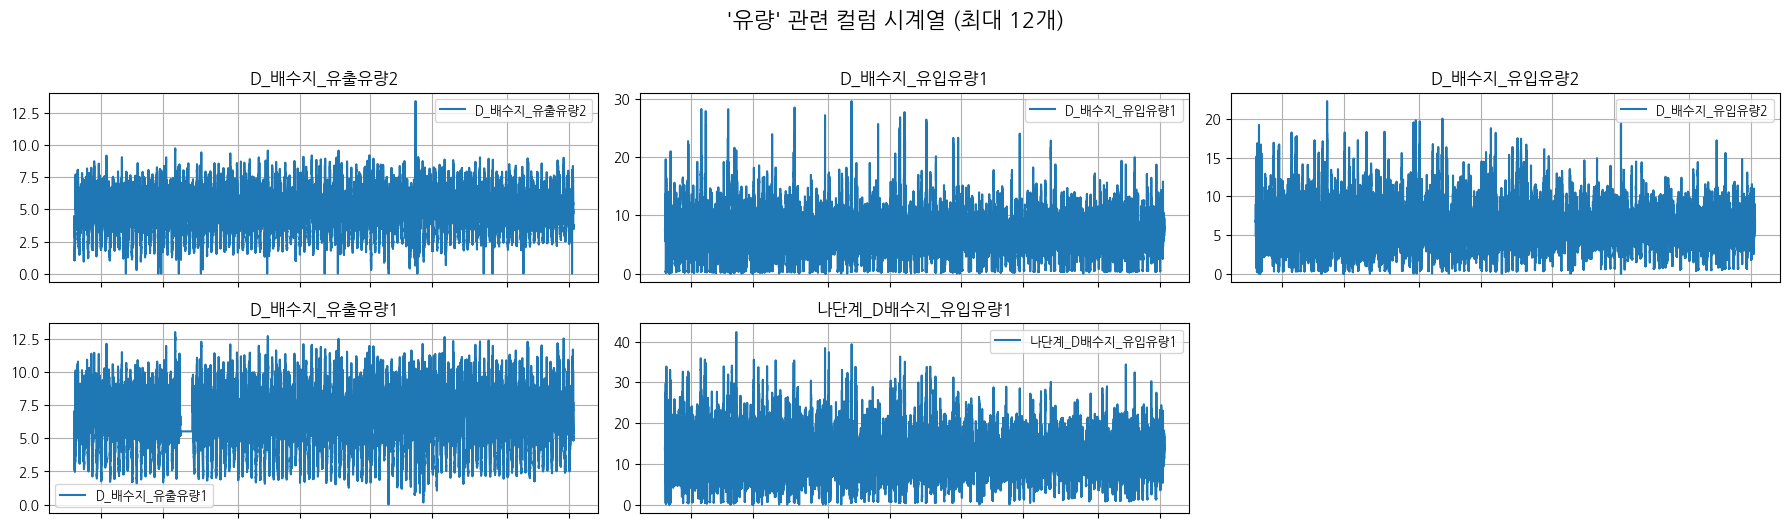

In [23]:
# 예: 수위 관련 컬럼 중 최대 6개만 2행 3열로 시각화
plot_columns_with_keyword(DF, keyword='유량', max_cols=12, layout=(4, 3))

#### 수위 이상치 처리

In [24]:
thresholds_by_reservoir = {
    'A': {'HH': 95, 'H': 90, 'L': 80, 'LL': 30},
    'B': {'HH': 98, 'H': 46, 'L': 37, 'LL': 30},
    'C': {'HH': 90, 'H': 80, 'L': 65, 'LL': 50},
    'D': {'HH': 95, 'H': 91, 'L': 80, 'LL': 65},
    'E': {'HH': 92, 'H': 76, 'L': 66, 'LL': 44},
    'F': {'HH': 99, 'H': 86, 'L': 60, 'LL': 33},
    'G': {'HH': 99, 'H': 88, 'L': 75, 'LL': 60},
    'H': {'HH': 98, 'H': 90, 'L': 81, 'LL': 46}
}

In [25]:
level_columns = [col for col in DF.columns if '수위' in col]

In [26]:
# 임계값(예: D배수지 기준)
thres = thresholds_by_reservoir["D"]

# '수위' 포함 컬럼만 필터링
level_columns = [col for col in DF.columns if '수위' in col]

for col in level_columns:
    # 문자열 → 숫자형
    DF[col] = pd.to_numeric(DF[col], errors='coerce')

    # 이상치 마스킹: HH 초과 또는 LL 미만
    outlier_mask = (DF[col] > thres['HH']) | (DF[col] < thres['LL'])

    # 이상치는 NaN 처리
    DF.loc[outlier_mask, col] = np.nan

    print(f"✅ D | {col} 이상치 {outlier_mask.sum()}건 → NaN 처리")

# bfill → ffill 순으로 보간(모든 숫자형 컬럼)
numeric_cols = DF.select_dtypes(include='number').columns
DF[numeric_cols] = DF[numeric_cols].bfill().ffill()

✅ D | D_배수지_수위2 이상치 42291건 → NaN 처리
✅ D | D_배수지_수위1 이상치 53297건 → NaN 처리
✅ D | D_배수지_수위8 이상치 53340건 → NaN 처리
✅ D | D_배수지_수위7 이상치 49525건 → NaN 처리


In [28]:
def plot_level_with_grades(df, level_col, reservoir_name=None, save=False, thresholds=None):
    if thresholds is None:
        raise ValueError("thresholds 인자가 필요합니다.")

    # 등급 계산을 따로 수행 (컬럼 생성 없이)
    def label_value(val):
        if pd.isna(val):
            return None
        elif val >= thresholds['HH']:
            return 'HH'
        elif val >= thresholds['H']:
            return 'H'
        elif val >= thresholds['L']:
            return 'L'
        elif val >= thresholds['LL']:
            return 'LL'
        else:
            return None

    grade_labels = df[level_col].apply(label_value)

    # 시각화
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df[level_col], label='수위(%)', color='gray', linewidth=1.5, zorder=1)

    # 등급별 색상
    grade_colors = {
        'HH': 'red',
        'H': 'orange',
        'L': 'blue',
        'LL': 'purple'
    }

    for grade, color in grade_colors.items():
        mask = grade_labels == grade
        plt.scatter(df.index[mask], df[level_col][mask], color=color, label=grade, s=10, zorder=2)

    plt.title(f"{reservoir_name or ''} | {level_col} 등급별 수위 시계열", fontsize=14)
    plt.ylabel("수위 (%)")
    plt.xlabel("시각")
    plt.legend(loc='upper right')  # 예: 오른쪽 위
    plt.grid(True)
    plt.tight_layout()
    plt.show()


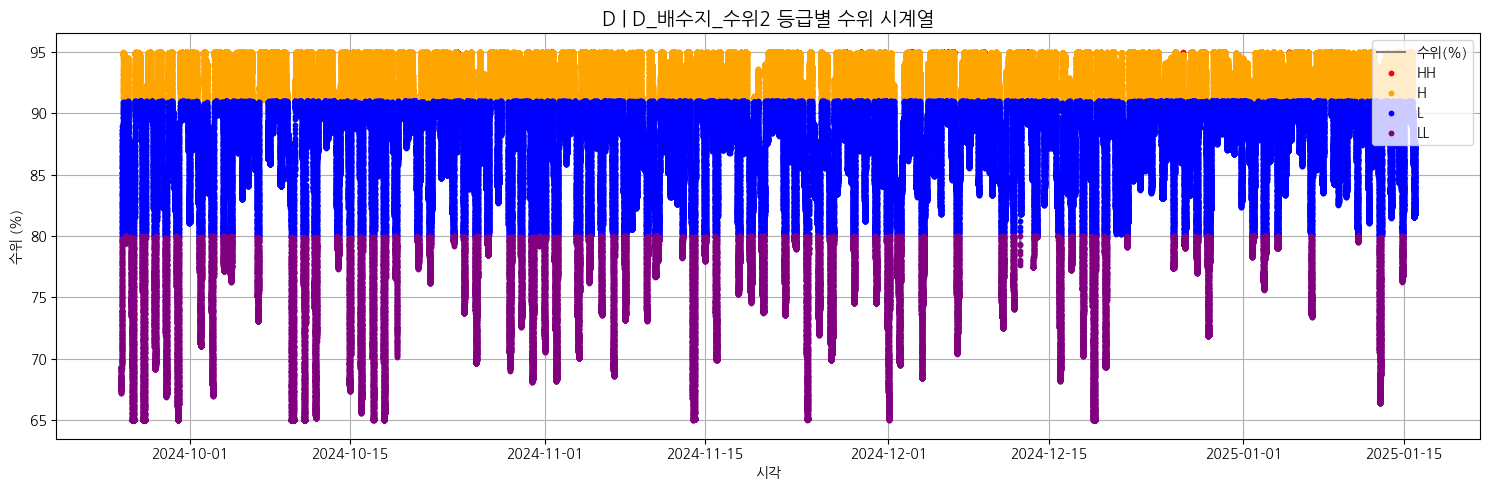

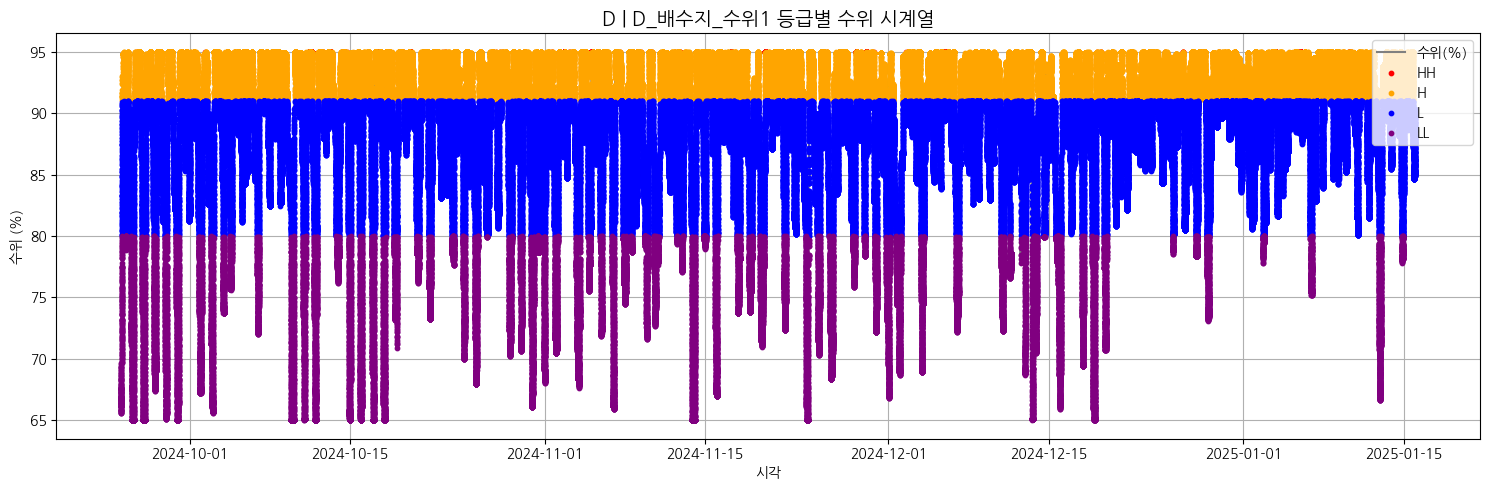

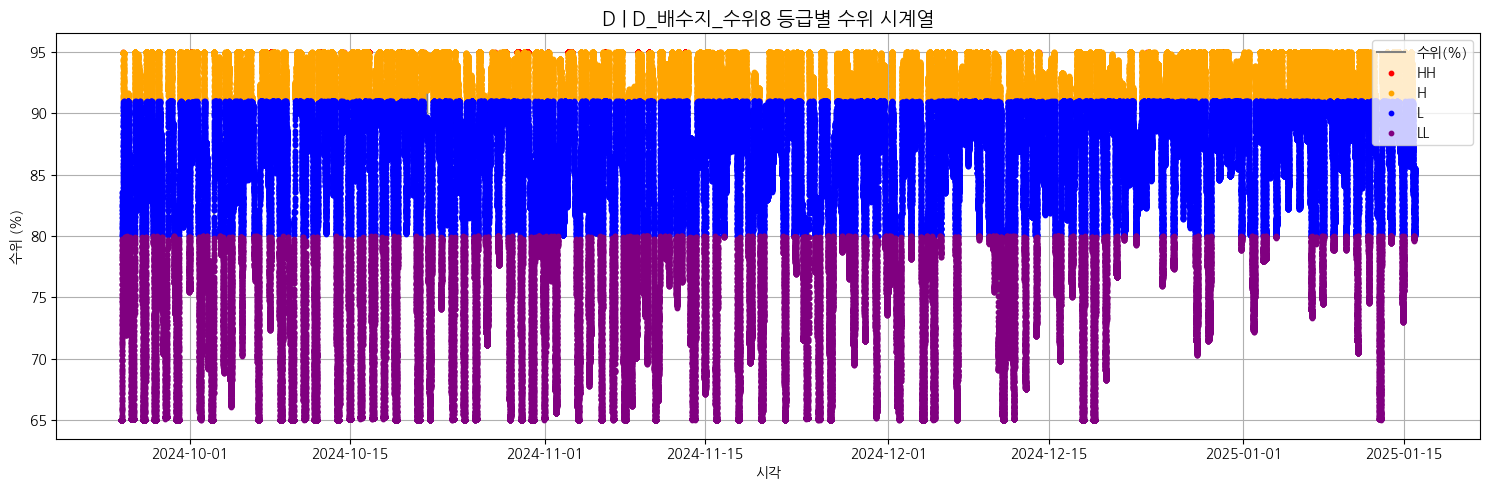

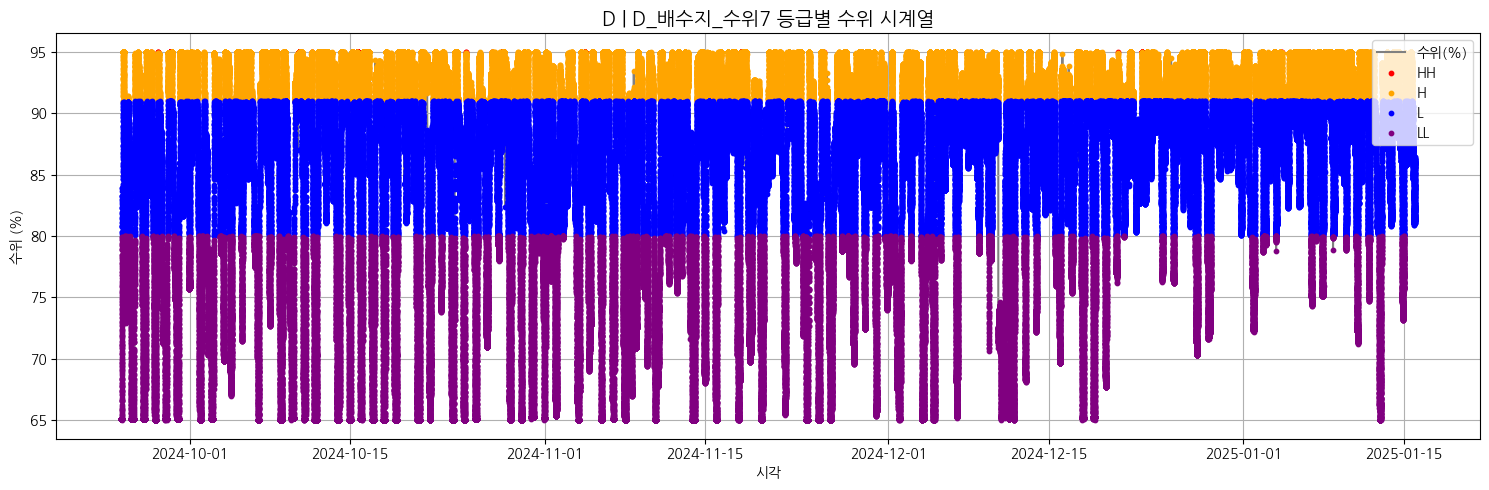

In [29]:
# D배수지의 기준값(임계값)만 적용
thres = thresholds_by_reservoir['D']
for col in level_columns:
    plot_level_with_grades(DF, level_col=col, reservoir_name='D', thresholds=thres)

✅ 유량 컬럼 5개: ['D_배수지_유출유량2', 'D_배수지_유입유량1', 'D_배수지_유입유량2', 'D_배수지_유출유량1', '나단계_D배수지_유입유량1']


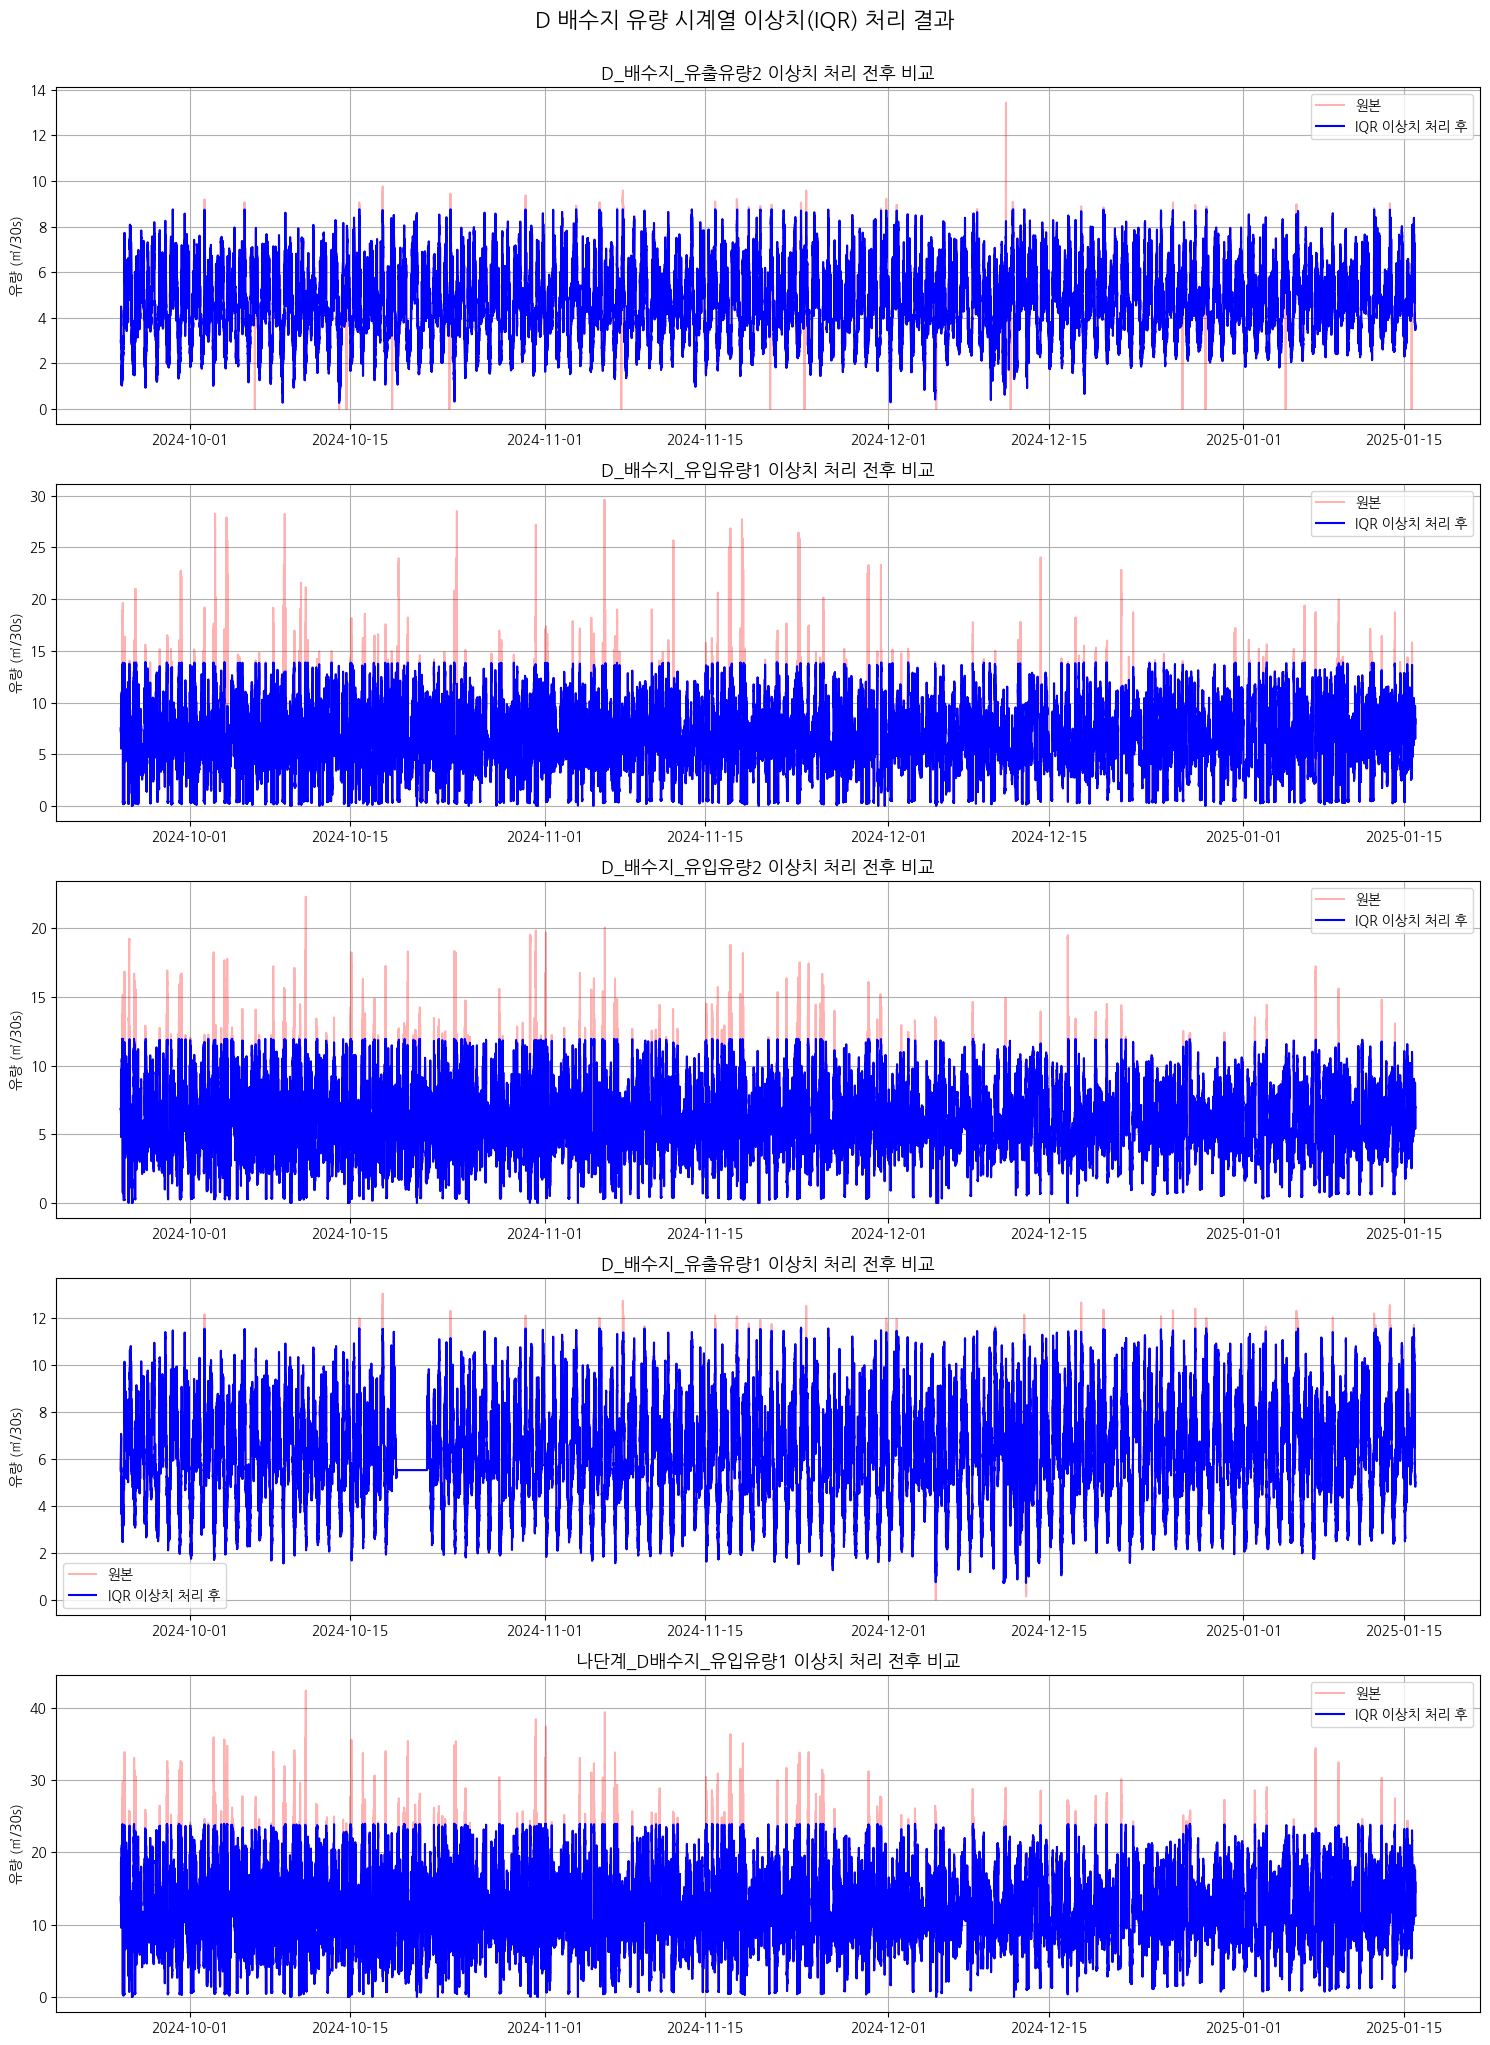

In [30]:
# 이상치 처리 대상: '유량' 들어간 모든 컬럼
flow_cols = [col for col in DF.columns if '유량' in col]
print(f"✅ 유량 컬럼 {len(flow_cols)}개:", flow_cols)

# 처리 결과 저장용 복사본

D_DF0 = DF.copy()


# 이상치 처리 루프 (IQR 방식 → NaN → 보간)
for col in flow_cols:
    Q1 = DF[col].quantile(0.25)
    Q3 = DF[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # 이상치 → NaN
    DF[col] = DF[col].mask((DF[col] < lower) | (DF[col] > upper))

# NaN 보간: 시간 기반 + ffill + bfill
DF[flow_cols] = DF[flow_cols].interpolate(method='time').ffill().bfill()

# 시각화: 원본 vs 이상치 처리 후 비교
plt.figure(figsize=(15, 4 * len(flow_cols)))

for i, col in enumerate(flow_cols, 1):
    plt.subplot(len(flow_cols), 1, i)
    plt.plot(D_DF0.index, D_DF0[col], label='원본', color='red', alpha=0.3)
    plt.plot(DF.index, DF[col], label='IQR 이상치 처리 후', color='blue')
    plt.title(f"{col} 이상치 처리 전후 비교", fontsize=13)
    plt.ylabel("유량 (㎥/30s)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("D 배수지 유량 시계열 이상치(IQR) 처리 결과", fontsize=16, y=1.02)
plt.show()

In [31]:
# 수위(%) → 수위량(m³) 변환을 위한 용량 맵
volume_map = {
    "A": {"수위1": 2000, "수위2": 2000, "수위3": 2000, "수위4": 2000},
    "B": {"수위1": 2500, "수위2": 2500},
    "C": {"수위1": 1500, "수위2": 1500, "수위3": 500, "수위4": 1250, "수위5": 1250},
    "D": {"수위1": 1800, "수위2": 1800, "수위3": 6200, "수위4": 6200, "수위5": 6200, "수위6": 6200, "수위7": 6200, "수위8": 6200},
    "E": {"수위1": 2850, "수위2": 2850, "수위3": 1050, "수위4": 1050},
    "F": {"수위1": 6500, "수위2": 6500, "수위3": 20000, "수위4": 20000},
    "G": {"수위1": 3000, "수위2": 3000},
    "H": {"수위1": 3000, "수위2": 3000, "수위3": 100000, "수위4": 100000, "수위5": 100000, "수위6": 100000}
}

In [ ]:
import re

def convert_water_level_to_volume_single(D_DF, volume_map, reservoir_name):
    if reservoir_name not in volume_map:
        print(f"⚠️ {reservoir_name}은 volume_map에 정의되어 있지 않음")
        return D_DF

    for col in D_DF.columns:
        if "수위" in col:
            match = re.search(r'(수위\d+)', col)
            if match:
                level_key = match.group(1)
                if level_key in volume_map[reservoir_name]:
                    capacity = volume_map[reservoir_name][level_key]
                    new_col = col + "_m3"
                    D_DF[new_col] = D_DF[col] * (capacity / 100)
                else:
                    print(f"⚠️ {reservoir_name}의 {level_key}는 volume_map에 없음")
    return D_DF

In [ ]:
DF = convert_water_level_to_volume_single(DF, volume_map, 'D')

In [34]:
import os

# 저장 폴더 지정
save_dir = "./result"
os.makedirs(save_dir, exist_ok=True)  # 폴더 없으면 자동 생성

# 저장 경로
save_path = os.path.join(save_dir, "processed.csv")

# 저장
DF.to_csv(save_path, encoding='utf-8-sig', index=True)
print(f"✅ processed.csv 저장 완료: {save_path}")

✅ processed.csv 저장 완료: ./result\processed.csv
